# Neural network design from scratch


### We would design a trainable neural network that can be parameterized to form shallow to deep neural network. And use a simple petal dataset to train

#### Import required python packages

In [161]:
# Numpy package for numerical operation
import numpy as np

# Matplotlin for plots
from matplotlib import pyplot as plt

# Set seed for stabilized result
np.random.seed(1)

#### Dataset for training neural network

In [162]:
# Create a dataset have coordinates for flower petals classified in two category
# We are creating a dataset that would be easy to visualize and train

def gen_petal_dataset(): 
    np.random.seed(1) # for stabilized result
    m = 400 # number of data points
    D = 2 # number of class
    N = int(m/D) # number of data points per class      
    X = np.zeros([m,D]) # data matrix where each row is a single example 
    Y = np.zeros([m,1], dtype='uint8') # labels petals (0 for red, 1 for blue) 
    a = 4 # maximum petals of the flower per class
  
 
    for j in range(2): # For 2 classes
        ix = range(N*j,N*(j+1)) # Row indexes for data points
        t = np.linspace(j*np.pi,(j+1)*np.pi,N) + np.random.randn(N)*0.2 # theta with some noise
        r = 4*np.sin(a*t) + np.random.randn(N)*0.2 # sinosoidal radius with some noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # Convert polar co-ordinates to cartesian co-ordinates
        Y[ix] = j # Copy the class
         
    X = X.T # Transpose the matrix to have rows as co-ordinate pairs and columns as data-points
    Y = Y.T # Transpose in accordance with X
  
    return X, Y 

# Load the dataset
X,Y=gen_petal_dataset()

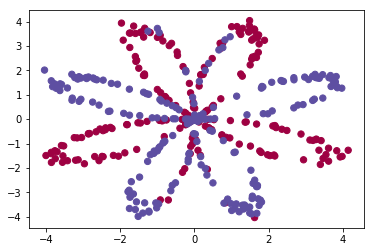

In [163]:
# plot the dataset - petals of the flower
plt.scatter(X[0, :], X[1, :], c = np.squeeze(Y), s=40, cmap=plt.cm.Spectral);

#### Define functions to build neural network

In [164]:
# 1) Parameter initialization
# layers : list of number of units in each layer from 0 to L where L is total number of layers
# Forward values : Values used in forward propagation
# Backward grads : Values used in backward propagation

# 2) Activation function
# Define activation function for sigmoid, tanh, relu and leaky-relu
# Sigmoid function g(z) = 1/(1+e^-z)
# tanh function g(z) = (e^z-e^-z)/(e^z+e^-z)
# relu function g(z) = max(0,z)
# leaky relu function g(z) = max(0.01z,z)


# 3) Gradient function for activations
# For each activation function mentioned above, define function to evaluate its gradient
# Gradient of Sigmoid function g'(z) = g(z)(1-g(z))
# Gradient of tanh function g'(z) = 1-g(z)^2
# Gradient of relu function g'(z) = 1 (if z >= 0) and 0 (if z < 0)
# Gradient of leaky relu function g'(z) = 1 (if z >= 0) and 0.01 (if z < 0)

# Note: Mathematically, gradient of relu and leaky relu is NOT defined at 0 however here we assume 1

In [165]:
# Initialize learnable parameters W and b
def initialize_parameter(parameters):
    layers, _, _ = parameters
    W={}; b={}; Z={}; A={};    
    dW={}; db={}; dZ={}; dA={};    
    np.random.seed(2)     # for stability of results
    for layer in range(len(layers))[1:]:  # Initilize W, b randomly with values close to 0
        W[layer] = np.random.randn(layers[layer],layers[layer-1])*0.01
        b[layer] = np.random.randn(layers[layer],1)*0.01
        assert(W[layer].shape==(layers[layer],layers[layer-1]))
        assert(b[layer].shape==(layers[layer],1))
    forward_values = [W, b, Z, A] # Values for forward propagation
    backward_grads = [dW, db, dZ, dA] # Gradients for Backward propagation
    return(forward_values,backward_grads)


# Activation function 
def activation(z, g):
    if g == 'sigmoid':
        result = 1/(1+np.exp(-z))
    elif g == 'relu':
        result = z*(z>0)
    elif g == 'lrelu':
        result = z*(z>0) + 0.01*z*(z<0)
    elif g == 'tanh':
        result = np.tanh(z)
    else :
        result = z
    assert(z.shape == result.shape)
    return(result)
    
# Activation_gradient function 
def activation_gradient(z, g):
    if g == 'sigmoid':
        activ_out = activation(z,g)
        result = np.multiply(activ_out,(1-activ_out))
    elif g == 'relu':
        result = 1*(z>0)
    elif g == 'lrelu':
        result = 1*(z>0) + 0.01*(z<0)
    elif g == 'tanh':
        activ_out = activation(z,g)
        result = 1-np.power(activ_out,2)
    else :
        result = np.ones(z.shape)
    assert(z.shape == result.shape)
    return(result)

In [166]:
# Forward propagation is propagating values from Input layer , through different layers with initiliazed parameters,
# to output layer. Below is what we calculate in each layer
# Z[l]=W[l].A[l-1]+b[l], A[l]=g(Z[l]) where Z and A are matrixs over m data points,
# . is dot product
# A is the activation value of each layer
# g() is the activation function.
# Z is input to activation units
# W is weights and b is the bias for each layer
# l(layer) is the layer that ranges from 0 to L(total number of layers)
# m is the number of data points inputted into the system
# X is the input and also the 0th layer activation values, i.e A[0] 
# G is the list of activation function layerwise
# Propagation of values A[0] --> Z[1] --> A[1] --> ... --> Z[l] --> A[l] --> ... --> Z[L] --> A[L]

# Cost function evaluates the cost of predicting output value incorrectly.
# Cost is evaluated as average value of loss, i.e. (1/m) of Loss 
# For single output unit predicting 2 class, this is evaluated as 
# (1/m)*(-1)* Sum of (YlogY` + (1-Y)log(1-Y')) over m data points
# For multiple output units predicting more than 1 class, this is evaluated as 
# (1/m)*(-1)* Sum of (YlogY` over each units in output layer)  over m data points
# Y is the actual output. 
# Y` is predicted output of last layer based on forward propagation after an iteration. This is also same as A[L]

# Loss gradient function (dloss) is gradient of loss function used to calculate cost
# For single output unit predicting 2 class, this is evaluated as 
# (-1)* Sum of (Y/Y` - (1-Y)/(1-Y')) = (A[L]-Y)/A[L]/(1-A[L]) over m data points
# For multiple output units predicting more than 1 class, this is evaluated as 
# (-1)* Sum of (Y/Y` or Y/A[L] over each units in output layer)  over m data points

# Backward propagation is propagating gradient in the backward direction. We would start with loss gradient, 
# propagating it through output layer, hidden layer to first layer. During propagation, we would also find
# gradient for parameters W and b - they are dW and db.
# dA[L] = dloss, dZ[L] = dA[L] * g'(Z) , dA[L-1] = T(W[l]).dZ[l]
# * is element-wise product
# T() is transpose function and propagartion is
# dA[L] --> dZ[L] --> ... --> dA[l] --> dZ[l] ---> ... ---> dA[1]
# and as by product of backward propagation, gradients dW and db are evaluated as
# dW[l] = (1/m) dZ[l].T(A[l-1]), db[l] = (1/m) sum over columns of dZ[l]

# Update parameter - functions
# For each layer update W and b as
# W[l] = W[l] - learning_rate x dW[l], b[l] = b[l] - learning_rate x db[l]


In [167]:
# Forward propagation
def forward_propagation(X, parameters, forward_values):
    layers, G, _ = parameters
    W, b, Z, A = forward_values    
    for layer in range(len(layers)):
        if layer == 0 :            
            Z[layer] = np.nan            
            A[layer] = X
        else :
            Z[layer] = np.dot(W[layer],A[layer-1]) + b[layer]
            A[layer] = activation(Z[layer],G[layer])
            assert(Z[layer].shape == (layers[layer],X.shape[1]))
            assert(A[layer].shape == (layers[layer],X.shape[1]))
    forward_values = W, b, Z, A
    return(forward_values)

# Cost function
def cost_function(Y, parameters, forward_values):
    layers, _, _ = parameters 
    _, _, _, A = forward_values
    output_units = layers[-1]
    e = 0.000000008 # To avoid divide by 0 error
    m = Y.shape[1]
    L = len(layers)-1
    if output_units == 1:
        loss = np.multiply(-1,np.multiply(Y,np.log(e+A[L])) + np.multiply(1-Y,np.log(e+1-A[L])))
    else:
        loss = np.multiply(-1,np.sum(Y*np.log(e+A[L])))
    cost = np.multiply((1/m),np.sum(loss))
    assert(isinstance(cost,float))
    return(cost)

# Loss Gradient
def loss_gradient(Y, parameters, forward_values):
    layers, _, _ = parameters 
    _, _, _, A = forward_values
    output_units = layers[-1]
    e = 0.000000008  # To avoid divide by 0 error
    L = len(layers)-1
    if output_units == 1:
        dloss = (e+A[L]-Y)/np.multiply(e+A[L],(e+1-A[L]))
    else:
        dloss = np.multiply(-1,np.sum(Y/A[L]))
    assert(dloss.shape == A[L].shape)
    return(dloss)

# Backward propagation
def backward_propagation(Y, parameters, forward_values, backward_grads):
    layers, G, alpha = parameters
    W, b, Z, A = forward_values     
    dW, db, dZ, dA = backward_grads
    m = Y.shape[1]
    for layer in reversed(range(len(layers))[1:]):                
        if layer == len(layers)-1 :
            dA[layer] = loss_gradient(Y, parameters, forward_values)
            dZ[layer] = np.multiply(dA[layer], activation_gradient(Z[layer],G[layer]))
        else :
            dA[layer] = np.dot(W[layer+1].T,dZ[layer+1])
            dZ[layer] = np.multiply(dA[layer], activation_gradient(Z[layer],G[layer]))
        dW[layer] = (1/m)*np.dot(dZ[layer],A[layer-1].T)
        db[layer] = (1/m)*np.sum(dZ[layer], axis=1,keepdims=True) 
    for layer in reversed(range(len(layers))[1:]):
        W,b = update_parameters(W,b,dW,db,layer,alpha)     
        assert(W[layer].shape==(layers[layer],layers[layer-1]))
        assert(b[layer].shape==(layers[layer],1))
        assert(Z[layer].shape==dZ[layer].shape)
    forward_values = W, b, Z, A
    backward_grads = dW, db, dZ, dA
    return(forward_values, backward_grads)        

def update_parameters(W,b,dW,db,layer,alpha):
    W[layer] = W[layer] - alpha*dW[layer]
    b[layer] = b[layer] - alpha*db[layer] 
    assert(W[layer].shape==dW[layer].shape)
    assert(b[layer].shape==db[layer].shape)
    return(W,b)


In [168]:
# Neuralnet classifier initializes the parameters for different layers defined with flexibility of
# definining number of units per layers, number of layers itself, learning rate and 
# activation function for each layer.


In [169]:
# Initialize classifier
def Neuralnet_clasifier(X, Y, params):
    
    # layers and units
    layers = [X.shape[0]]
    if 'hidden' in params.keys():
        hidden_layers = len(params['hidden'])
        if hidden_layers > 1:
            layers.extend(np.squeeze(params['hidden']))
        else :
            layers.append(np.squeeze(params['hidden']))
    layers.append(Y.shape[0])
    
    # Activation function
    Activation_function = [np.nan]
    if 'activations' in params.keys():
        Activation_function.extend(np.squeeze(params['activations']))
    else :
        Activation_function.extend(['tanh' for layer in range(hidden_layers)])
        Activation_function.append('sigmoid')
    assert(len(Activation_function) == len(layers))
    
    # Learning rate
    if 'alpha' in params.keys():
        assert(isinstance(params['alpha'],float))
        learning_rate = params['alpha']
    else :
        learning_rate = 1.2
           
    # Initialize model parameters
    parameters = [layers, Activation_function, learning_rate]
    forward_values, backward_grads = initialize_parameter(parameters)
    
    return(parameters, forward_values, backward_grads)

In [170]:
# Once Neuralnet is initialized, the parameters are then be trained using inputs and labels using
# iterations of forward propagation and backward propagation with an objective of brining the cost down.

# With the learned parameters, output can be predicted using propagation and values would be the probability
# of the class.

In [171]:
# training and prediction function
def Neuralnet_training(X, Y, parameters, forward_values, backward_grads, iterations = 10000, cost_print = True):
    for iteration in range(iterations):
        forward_values = forward_propagation(X, parameters, forward_values)        
        cost = cost_function(Y, parameters, forward_values)    
        forward_values, backward_grads = backward_propagation(Y, parameters, forward_values, backward_grads)
        if iteration % 1000 == 0:
            print("After {} iteration/s , cost is {}".format(iteration,cost))    
    return(forward_values, backward_grads)

def Neuralnet_predict(X, parameters, forward_values):
    layers, _, _ = parameters 
    L = len(layers)-1
    forward_values = forward_propagation(X, parameters, forward_values)
    _, _, _, A = forward_values
    return(A[L] > 0.5)

#### Initialize the model, train using the data (X and Y) and predict the output on X

In [172]:
# Initialize model 
params = {}
params['hidden'] = [5,5,4] # Hidden layers with units
params['activations'] = ['tanh','tanh','tanh','sigmoid'] # Activation functions for hidden layer and output layer
params['alpha'] = 1.2  # Learning rate 
 
parameters, forward_values, backward_grads =  Neuralnet_clasifier(X, Y, params)

In [173]:
# Training the initialized neuralnet with data X and Y
forward_values, backward_grads = Neuralnet_training(X, Y, parameters, forward_values, backward_grads,
                                                    iterations = 30000)

After 0 iteration/s , cost is 0.6931472002416261
After 1000 iteration/s , cost is 0.6931471548393605
After 2000 iteration/s , cost is 0.6931471472700105
After 3000 iteration/s , cost is 0.6931471344059367
After 4000 iteration/s , cost is 0.6931471089580314
After 5000 iteration/s , cost is 0.6931470469725183
After 6000 iteration/s , cost is 0.6931468278803127
After 7000 iteration/s , cost is 0.6931446280929475
After 8000 iteration/s , cost is 0.31983525791490747
After 9000 iteration/s , cost is 0.2777299142388063
After 10000 iteration/s , cost is 0.23129681275318212
After 11000 iteration/s , cost is 0.2172798358063677
After 12000 iteration/s , cost is 0.19377659687564394
After 13000 iteration/s , cost is 0.185325001972198
After 14000 iteration/s , cost is 0.18335596949587413
After 15000 iteration/s , cost is 0.16828288636775277
After 16000 iteration/s , cost is 0.19318192394740077
After 17000 iteration/s , cost is 0.18651396643113383
After 18000 iteration/s , cost is 0.17311413635468445

In [174]:
# Prediction on training data
pred = Neuralnet_predict(X, parameters, forward_values)
print("Accuracy on training data is {} %".format(np.sum(pred == Y)*100/Y.shape[1]))

Accuracy on training data is 91.5 %


#### Plot the decision boundary of the trained neuralnet classifier

In [175]:
# Function to plot decision boundary
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


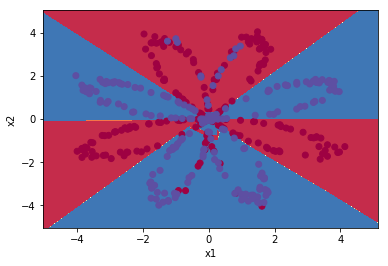

In [176]:
# Plot the decision boundary
plot_decision_boundary(lambda x: Neuralnet_predict(x.T, parameters, forward_values), X, np.squeeze(Y))